# ACCESS-OM2 0.25$^\circ$

This notebook documents our first attempt to run and analyse output from the [ACCESS-OM2 Pre-release](https://github.com/OceansAus/access-om2), implemented at 0.25°.


## Current Status


|** Run Name** | **Forcing** | ** Run ** | ** Status **|
|--------------|---------|-------------------------------------------------|-------------|
|025deg_jra55_ryf_spinup1 | JRA55 RYF9091| This is our initial 0.25° test. Ran for a decade before sea ice build-up overwhelmed us!  | Aborted after 10 years.| 
|025deg_jra55_ryf_spinup2 | JRA55 RYF9091| This is our initial 0.25° test with the sea ice parameter fixed. Less sea ice buildup, but there seems to be a problem with salinity conservation. It seems we are not doing runoff properly ... | Stopped at 50 years.| 
|025deg_jra55_ryf_spinup3 | JRA55 RYF9091| Third attempt at 0.25° test. This run is very unstable, and we think it might be something to do with runoff. Will try to fix this and start again. | Up to 8 years. **Ignore run: problems with landmasking tiles.**| 
|025deg_jra55_ryf_spinup4 | JRA55 RYF9091| Latest attempt at 0.25° test. Also unstable, due to ice-ocean interaction in Arctic - see <https://github.com/OceansAus/access-om2/issues/21> | Stopped at year 5| 
|025deg_jra55_ryf_spinup5 | JRA55 RYF9091| AK's spinup at 0.25°. `max_ice_thickness=0.0` to hopefully stabilise ice-ocean, following Griffies' suggestion. riverspread also on. | 5yr @ dt=540s, 2yr @ dt=600s, 5yr @ dt=900s, dt=1080s running; additional diagnostics (pressure, rho, river, runoff, ice_calving, evap, melt and surface salt flux) from year 8. Crashed with dt=1800s. Stopped at year 17 (abondoned to try Nic's ice fix). | 
|025deg_jra55_ryf_spinup6 | JRA55 RYF9091| As for 025deg_jra55_ryf_spinup5 but now with Nic's ice fix | 2yr @ dt=540s, dt=600s. Stopped at year 3 as Nic found a bug. | 
|025deg_jra55_ryf_broadwell_test | JRA55 RYF9091| AK's 3rd spinup, also testing running on normalbw queue (ran from run-025deg_jra55_ryf_spinup5 setup without recompiling for broadwell). This run was more stable, but retains salt imbalances. | 8yr @ dt=540s, 3yr @ dt=900s, 3yr @ dt=1350s, rest at dt=1800s (barotropic CFL marginally violated at dt=2360s). normalbw cost 3.8% more despite being charged 25% more than normal. Runs are substantially faster and the queue wait is much less. There's also a 1% penalty for requesting 1960 CPUs when only 1936 are used, and (according to Marshall) 3% for not compiling with -xCORE-AVX2. Stopped at year 32.| 
|025deg_jra55_ryf_spinup7 | JRA55 RYF9091| New binaries, no riverspred, weightless ice, and Nic's ice fix. salt_global_ave, eta_global now very steady. :-) | 2yr @ dt=600s, 2yr @ dt=900s, 1yr @ dt=1350s, then dt=1800s out to 22+ yrs, still running. | 


** TODO: automate some of this record keeping, e.g. using `cc.summary_md` and **
```
grep  -m 1 timestep /g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup2/output*/config.yaml | sed -n 's/^.*output/output/p' | sed -e 's/\/config.yaml:     //g'
```
** - actually it would be better to have cc.build_index also index .nml and config.yaml files and PBS output logs... **

### To Do Next
* Check Arctic tripolar winds

**Last updated 8 September 2017**

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import seaborn as sns
sns.set_style('whitegrid', {'grid.color': '.9',
                            'legend.frameon': True})

In [2]:
cc.build_index()

Searching /g/data3/hh5/tmp/cosima/
Searching /g/data1/v45/APE-MOM
Found 56426 .nc files
Using database sqlite:////g/data1/v45/cosima-cookbook/cosima-cookbook.db
Files already indexed: 50480
Files found but not yet indexed: 5946
Indexing new .nc files...
[########################################] | 100% Completed |  0.8s
Found 1301 new variables
Saving results in database...
Indexing complete.


True

## Experiments

In [3]:
# get a full list of relevant experiments
configuration = 'access-om2-025'
expts = cc.get_experiments(configuration)
expts.sort()
expts.append('mom025_jra_ryf9091') # MOM-SIS as a reference
display(expts)
#cc.summary_md(configuration,expts)

# This subset of cases are the important ones
esub = expts.copy()
# esub.pop(6)
# esub.pop(5)
# esub.pop(4)
# esub.pop(3)
# esub.pop(1)
display(esub)
cc.summary_md(configuration,esub)

['025deg_jra55_ryf_broadwell_test',
 '025deg_jra55_ryf_spinup1',
 '025deg_jra55_ryf_spinup2',
 '025deg_jra55_ryf_spinup3',
 '025deg_jra55_ryf_spinup4',
 '025deg_jra55_ryf_spinup5',
 '025deg_jra55_ryf_spinup6',
 '025deg_jra55_ryf_spinup7',
 'mom025_jra_ryf9091']

['025deg_jra55_ryf_broadwell_test',
 '025deg_jra55_ryf_spinup1',
 '025deg_jra55_ryf_spinup2',
 '025deg_jra55_ryf_spinup3',
 '025deg_jra55_ryf_spinup4',
 '025deg_jra55_ryf_spinup5',
 '025deg_jra55_ryf_spinup6',
 '025deg_jra55_ryf_spinup7',
 'mom025_jra_ryf9091']

### atmosphere/input_atm.nml namelist differences

| group | variable | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_broadwell_test/<br>output000/<br>atmosphere/<br>input_atm.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup1/<br>output000/<br>atmosphere/<br>input_atm.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup2/<br>output000/<br>atmosphere/<br>input_atm.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup3/<br>output000/<br>atmosphere/<br>input_atm.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup4/<br>output000/<br>atmosphere/<br>input_atm.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup5/<br>output000/<br>atmosphere/<br>input_atm.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup6/<br>output000/<br>atmosphere/<br>input_atm.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup7/<br>output000/<br>atmosphere/<br>input_atm.nml | 
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| &coupling | dt_atm | 540 | 540 | 540 | 540 | 540 | 540 | 540 | 600 | 
| &coupling | runtime | 31536000 | 31536000 | 31536000 | 15638400 | 31536000 | 31536000 | 31536000 | 31536000 | 

### ice/cice_in.nml namelist differences

| group | variable | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_broadwell_test/<br>output000/<br>ice/<br>cice_in.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup1/<br>output000/<br>ice/<br>cice_in.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup2/<br>output000/<br>ice/<br>cice_in.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup3/<br>output000/<br>ice/<br>cice_in.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup4/<br>output000/<br>ice/<br>cice_in.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup5/<br>output000/<br>ice/<br>cice_in.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup6/<br>output000/<br>ice/<br>cice_in.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup7/<br>output000/<br>ice/<br>cice_in.nml | 
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| &forcing_nml | calc_strair | True | False | True | True | True | True | True | True | 
| &forcing_nml | calc_tsfc | True | False | True | True | True | True | True | True | 
| &grid_nml | grid_file | 'RESTART/grid.nc' | 'INPUT/grid.nc' | 'INPUT/grid.nc' | 'RESTART/grid.nc' | 'RESTART/grid.nc' | 'RESTART/grid.nc' | 'RESTART/grid.nc' | 'RESTART/grid.nc' | 
| &grid_nml | kmt_file | 'RESTART/kmt.nc' | 'INPUT/kmt.nc' | 'INPUT/kmt.nc' | 'RESTART/kmt.nc' | 'RESTART/kmt.nc' | 'RESTART/kmt.nc' | 'RESTART/kmt.nc' | 'RESTART/kmt.nc' | 
| &setup_nml | dt | 540 | 540 | 540 | 540 | 540 | 540 | 540 | 600 | 
| &setup_nml | npt | 58400 | 58400 | 58400 | 28960 | 58400 | 58400 | 58400 | 52560 | 

### ice/input_ice.nml namelist differences

| group | variable | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_broadwell_test/<br>output000/<br>ice/<br>input_ice.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup1/<br>output000/<br>ice/<br>input_ice.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup2/<br>output000/<br>ice/<br>input_ice.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup3/<br>output000/<br>ice/<br>input_ice.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup4/<br>output000/<br>ice/<br>input_ice.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup5/<br>output000/<br>ice/<br>input_ice.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup6/<br>output000/<br>ice/<br>input_ice.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup7/<br>output000/<br>ice/<br>input_ice.nml | 
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| &coupling_nml | dt_cpl_io | 540 | 540 | 540 | 540 | 540 | 540 | 540 | 600 | 
| &coupling_nml | rotate_winds | True | False | False | True | True | True | True | True | 

### ice/input_ice_gfdl.nml namelist differences

no differences

### ice/input_ice_monin.nml namelist differences

no differences

### ocean/input.nml namelist differences

| group | variable | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_broadwell_test/<br>output000/<br>ocean/<br>input.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup1/<br>output000/<br>ocean/<br>input.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup2/<br>output000/<br>ocean/<br>input.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup3/<br>output000/<br>ocean/<br>input.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup4/<br>output000/<br>ocean/<br>input.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup5/<br>output000/<br>ocean/<br>input.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup6/<br>output000/<br>ocean/<br>input.nml | /<br>g/<br>data3/<br>hh5/<br>tmp/<br>cosima/<br>access-om2-025/<br>025deg_jra55_ryf_spinup7/<br>output000/<br>ocean/<br>input.nml | 
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| &auscom_ice_nml | dt_cpl | 540 | 540 | 540 | 540 | 540 | 540 | 540 | 600 | 
| &ocean_model_nml | dt_ocean | 540 | 540 | 540 | 540 | 540 | 540 | 540 | 600 | 
| &ocean_model_nml | io_layout | [6, 5] |  |  |  | [6, 5] | [6, 5] | [6, 5] | [6, 5] | 
| &ocean_riverspread_nml | debug_this_module | False | False | False | False | False | False | False |  | 
| &ocean_riverspread_nml | riverspread_diffusion | True |  |  |  | True | True | True |  | 
| &ocean_riverspread_nml | riverspread_diffusion_passes | 2 |  |  |  | 2 | 2 | 2 |  | 
| &ocean_riverspread_nml | use_this_module | True | True | True | True | True | True | True | False | 
| &ocean_riverspread_nml | vel_micom_smooth | 0.2 |  |  |  | 0.2 | 0.2 | 0.2 |  | 
| &ocean_sbc_nml | max_ice_thickness | 0.0 | 8.0 | 8.0 | 8.0 | 8.0 | 0.0 | 0.0 | 0.0 | 
| &ocean_solo_nml | dt_cpld | 540 | 540 | 540 | 540 | 540 | 540 | 540 | 600 | 
| &ocean_solo_nml | months | 0 | 0 | 0 | 6 | 0 | 0 | 0 | 0 | 
| &ocean_solo_nml | years | 1 | 1 | 1 | 0 | 1 | 1 | 1 | 1 | 

## Wind Stress
Just a simple plot showing zonally averaged zonal wind stress from each case.


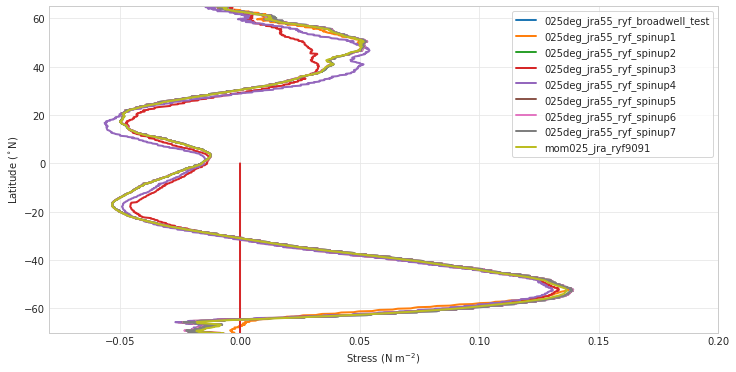

In [18]:
cc.plots.wind_stress(esub)

## Ocean Scalars
The following series of plots shows global timeseries of key metrics.

Calculating...done.


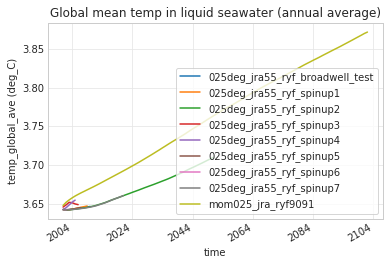

In [19]:
cc.plots.annual_scalar(esub, 'temp_global_ave')

Calculating...done.


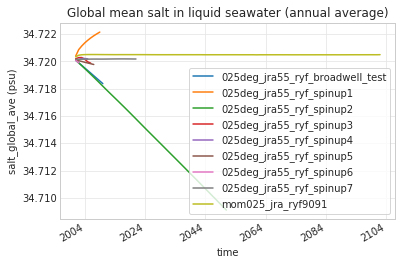

In [20]:
cc.plots.annual_scalar(esub, 'salt_global_ave')

Calculating...done.


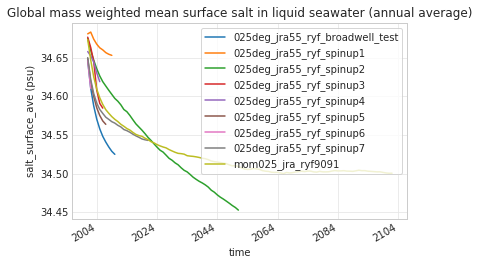

In [21]:
cc.plots.annual_scalar(esub, 'salt_surface_ave')

Calculating...done.


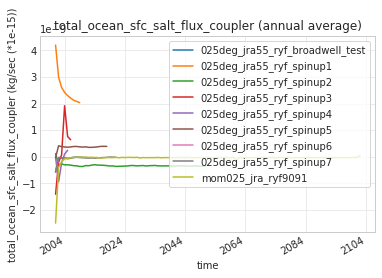

In [22]:
cc.plots.annual_scalar(esub, 'total_ocean_sfc_salt_flux_coupler')

Calculating...done.


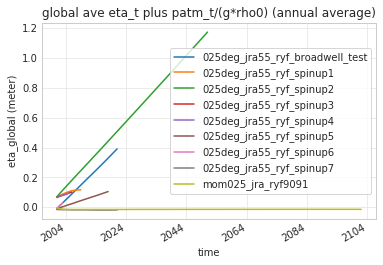

In [23]:
cc.plots.annual_scalar(esub, 'eta_global')

Calculating...done.


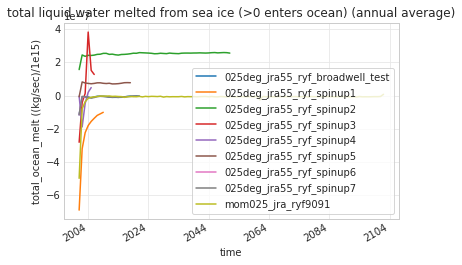

In [24]:
cc.plots.annual_scalar(esub, 'total_ocean_melt')

In [25]:
variables = cc.netcdf_index.get_scalar_variables(configuration)

In [26]:
from ipywidgets import widgets, interact, interactive, fixed

def myplot(expts, variable):
    plt.figure(figsize=(10,8))
    cc.plots.annual_scalar(expts, variable)
    plt.show()
    
interactive(myplot,
            expts=fixed(expts),
            variable=widgets.Dropdown(options=variables, description='Scalar Variable:'))

A Jupyter Widget

## Drake Passage Transport


{'xloc': 840, 'ymin': 110, 'ymax': 250}


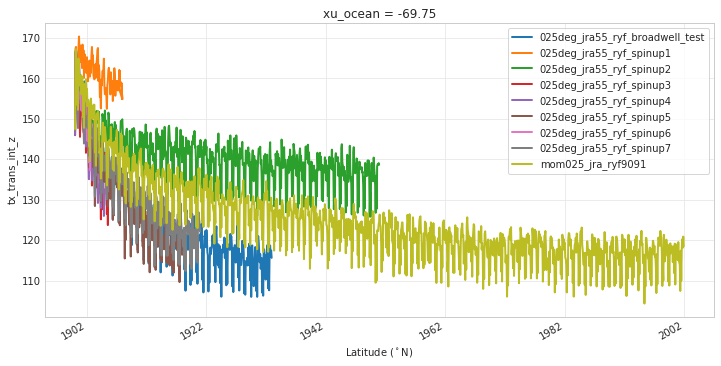

In [27]:
plt.figure(figsize=(12,6))
StraightDicts = { 'DrakePassage' :  {'xloc':840,'ymin':110,'ymax':250},}
TransDict = StraightDicts['DrakePassage']
print(TransDict)
for e in esub:
    tx = cc.get_nc_variable(e,'ocean_month.nc','tx_trans_int_z',chunks={'yt_ocean':200},
                         time_units = 'days since 1900-01-01').isel(xu_ocean=TransDict['xloc'])
    tx_trans = tx[:,TransDict['ymin']:TransDict['ymax']]
    if tx_trans.units == 'Sv (10^9 kg/s)':
        transport = tx_trans.sum('yt_ocean')
    else:
        print('WARNING: Changing units for ', e)
        transport = tx_trans.sum('yt_ocean')*1.0e-9
    transport.plot(label=e, linewidth=2)


plt.xlabel('Latitude ($^\circ$N)')
plt.legend(loc='upper right',fontsize=10)

## Overturning circulation
First we plot mean overturning for the final decade of the simulation.
Then we look at overturning timeseries.

** This calculation also needs us to treat landmasked tiles.**

In [28]:
def calc_psi_avg(expt):
    print('Calculating {} psi_avg'.format(expt))
    
    #op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                        #op=op,
                        chunks={'potrho': None}, time_units = 'days since 1900-01-01', n=10)
        
    if psi.units == 'kg/s':
        print('WARNING: Changing units for ', expt)
        psi = psi*1.0e-9

    psi_avg = psi.sum('grid_xt_ocean').cumsum('potrho').mean('time')
    psi_avg = psi_avg.compute()
    
    return psi_avg

In [29]:
def plot_psi(psi_avg, expt, clev=np.arange(-20,20,2)):

    plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

Calculating 025deg_jra55_ryf_broadwell_test psi_avg
Calculating 025deg_jra55_ryf_spinup1 psi_avg
Calculating 025deg_jra55_ryf_spinup2 psi_avg
Calculating 025deg_jra55_ryf_spinup3 psi_avg
Calculating 025deg_jra55_ryf_spinup4 psi_avg
Calculating 025deg_jra55_ryf_spinup5 psi_avg
Calculating 025deg_jra55_ryf_spinup6 psi_avg
Calculating 025deg_jra55_ryf_spinup7 psi_avg
Calculating mom025_jra_ryf9091 psi_avg


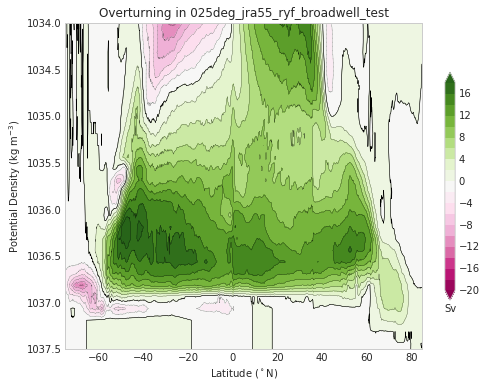

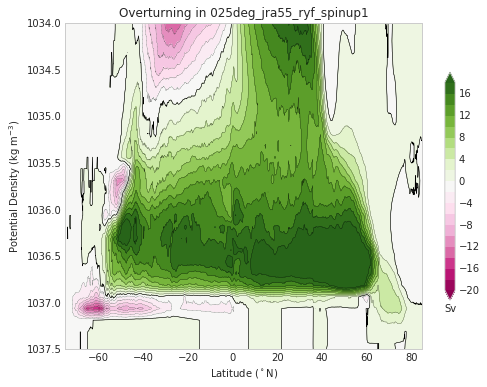

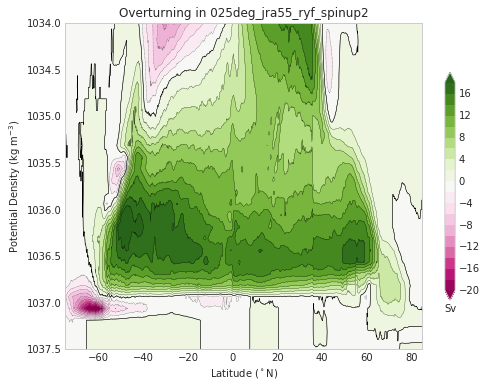

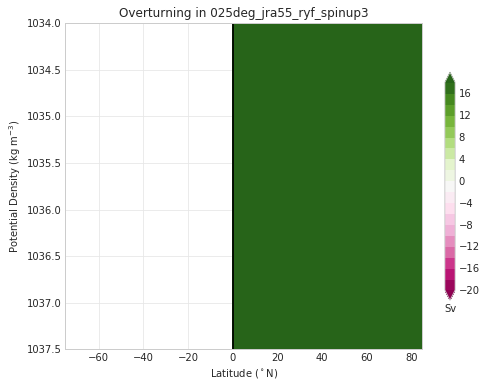

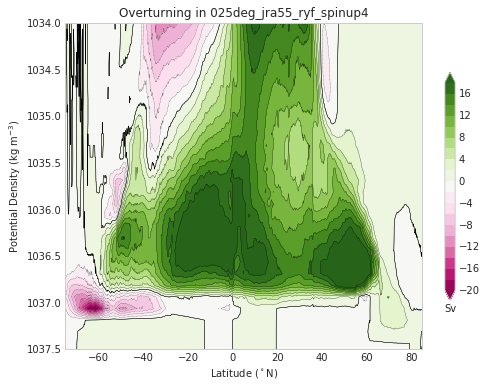

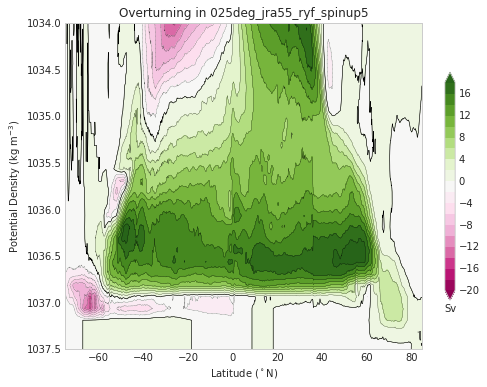

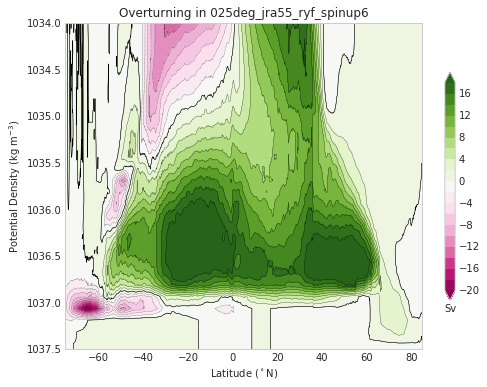

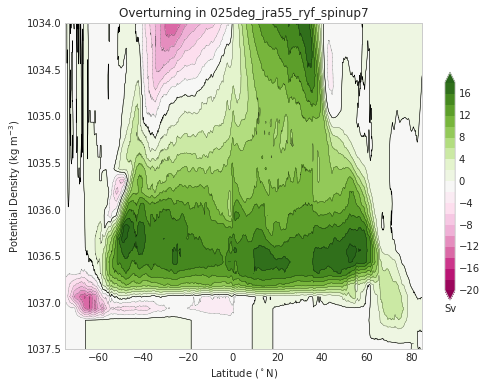

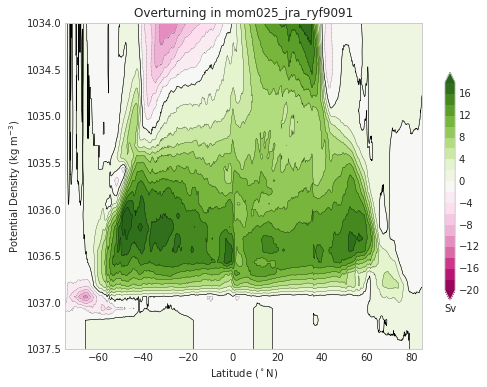

In [30]:
for e in esub: 
    plt.figure(figsize=(8, 6)) 
    psi_avg = calc_psi_avg(e)
    plot_psi(psi_avg, e)

In [31]:
def calc_psi_time(expt):
    print('Calculating {} timeseries of transport '.format(expt))
    
    #op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          #op=op,
                          chunks={'potrho': None},
                          time_units = 'days since 1900-01-01')
    
    if psi.units == 'kg/s':
        print('WARNING: Changing units for ', expt)
        psi = psi*1.0e-9
    
    psi_sum = psi.sum('grid_xt_ocean').cumsum('potrho')
    
    psi_aabw = psi_sum[:,60:,230].min('potrho').resample('3A',dim='time')
    psi_aabw = psi_aabw.compute()
    psi_amoc = psi_sum[:,60:,605].max('potrho').resample('3A',dim='time')
    psi_amoc = psi_amoc.compute()
    psi_amoc_south = psi_sum[:,60:,345].max('potrho').resample('3A',dim='time')
    psi_amoc_south = psi_amoc_south.compute()
    
    return psi_aabw, psi_amoc, psi_amoc_south

Calculating 025deg_jra55_ryf_broadwell_test timeseries of transport 
Calculating 025deg_jra55_ryf_spinup1 timeseries of transport 
Calculating 025deg_jra55_ryf_spinup2 timeseries of transport 
Calculating 025deg_jra55_ryf_spinup3 timeseries of transport 
Calculating 025deg_jra55_ryf_spinup4 timeseries of transport 
Calculating 025deg_jra55_ryf_spinup5 timeseries of transport 
Calculating 025deg_jra55_ryf_spinup6 timeseries of transport 
Calculating 025deg_jra55_ryf_spinup7 timeseries of transport 
Calculating mom025_jra_ryf9091 timeseries of transport 


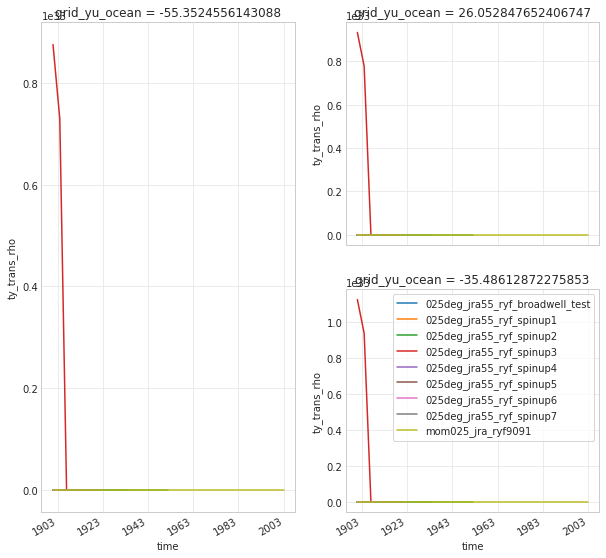

In [32]:
plt.figure(figsize=(10, 10)) 
for e in esub: 
    psi_aabw,psi_amoc,psi_amoc_south = calc_psi_time(e)
        
    plt.subplot(121)
    psi_aabw.plot()
    plt.subplot(222)
    psi_amoc.plot()
    plt.subplot(224)
    psi_amoc_south.plot(label=e)
    
plt.legend()

## Surface Temperature
Let's look at mean surface temperature averaged over the last decade. We will show the MOM-SIS case first, then look at differences between ACCESS-OM2 cases and MOM-SIS.

/home/156/aek156/cosima-cookbook/cosima_cookbook/netcdf_index.py:219: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


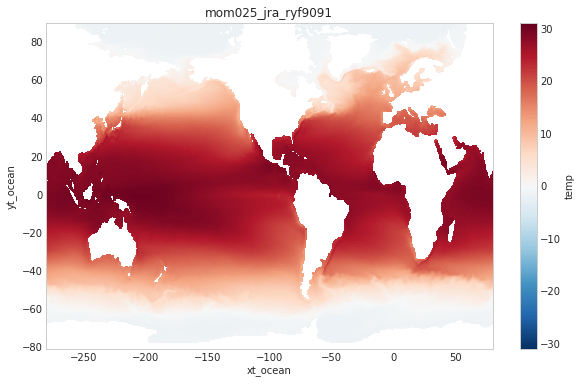

In [33]:
e = esub[-1]
plt.figure(figsize=(10, 6)) 
sst = cc.get_nc_variable(e, 'ocean.nc', 'temp',n=10).isel(st_ocean=0)
sst = sst.mean('time')
sst.plot()
plt.title(e)


/home/156/aek156/cosima-cookbook/cosima_cookbook/netcdf_index.py:219: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


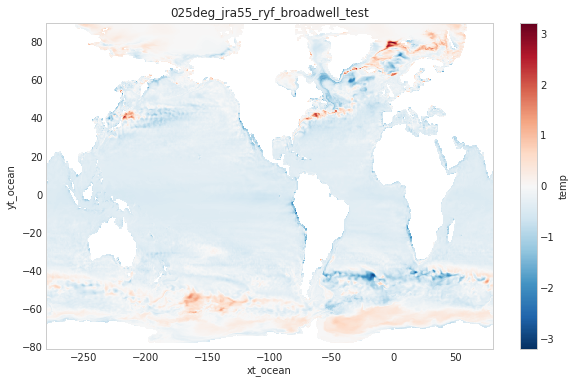

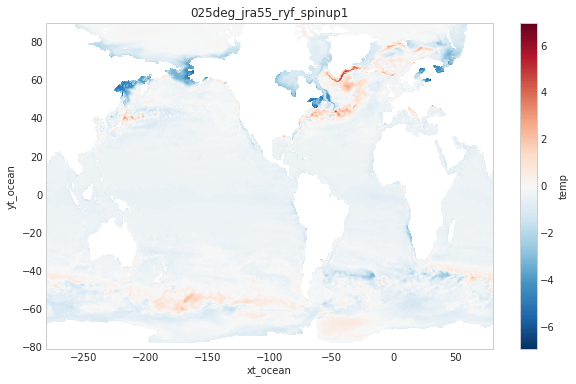

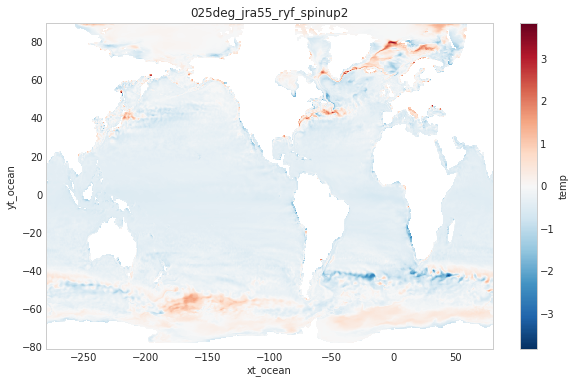

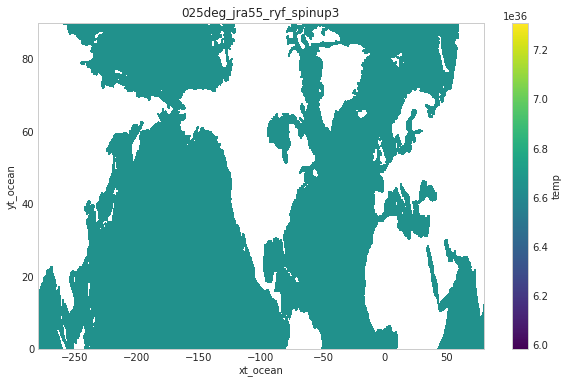

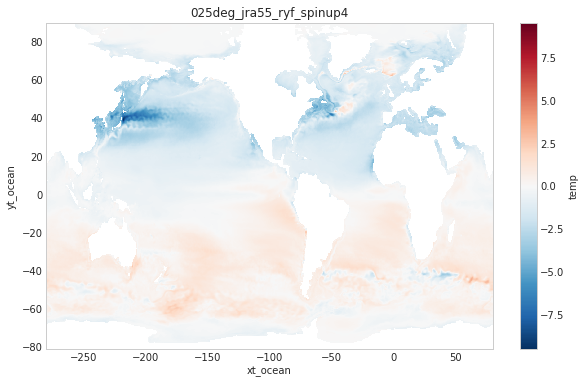

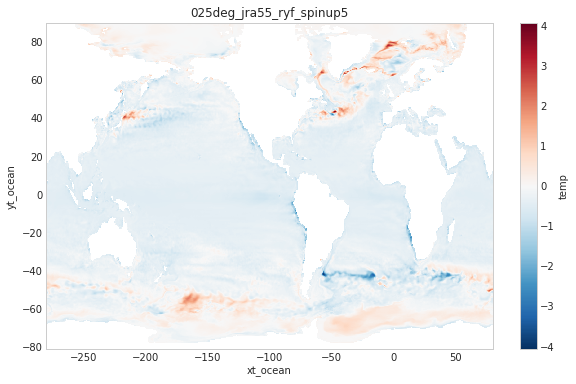

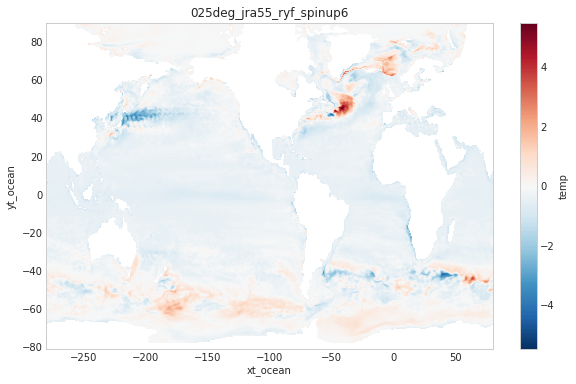

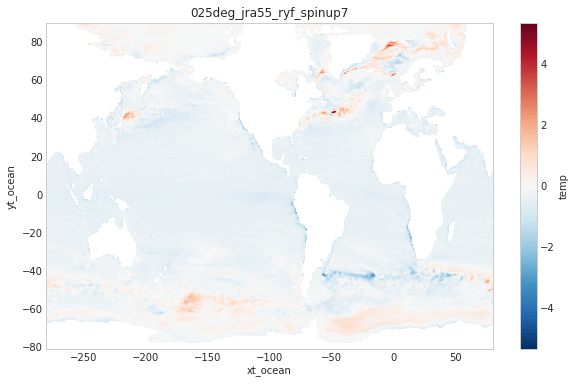

In [34]:
for e in esub[:-1]:
    plt.figure(figsize=(10, 6)) 
    sst2 = cc.get_nc_variable(e, 'ocean.nc', 'temp',n=10).isel(st_ocean=0)
    sst2 = sst2.mean('time') - 273.15
    diff = sst2 - sst.values
    diff.plot()
    plt.title(e)

## Surface Salinity
Let's look at mean surface salinity averaged over the last decade. We will show the MOM-SIS case first, then look at differences between ACCESS-OM2 cases and MOM-SIS.

/home/156/aek156/cosima-cookbook/cosima_cookbook/netcdf_index.py:219: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


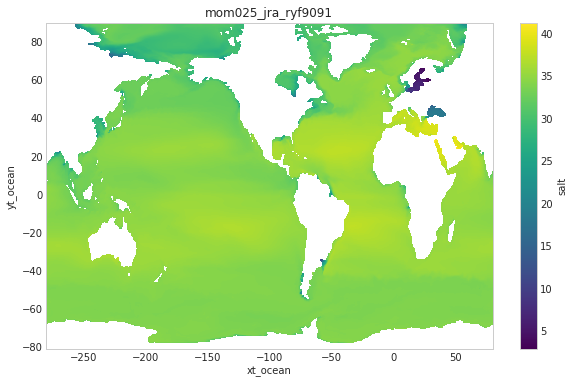

In [35]:
e = esub[-1]
plt.figure(figsize=(10, 6)) 
sss = cc.get_nc_variable(e, 'ocean.nc', 'salt',n=10).isel(st_ocean=0)
sss = sss.mean('time')
sss.plot()
plt.title(e)

/home/156/aek156/cosima-cookbook/cosima_cookbook/netcdf_index.py:219: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


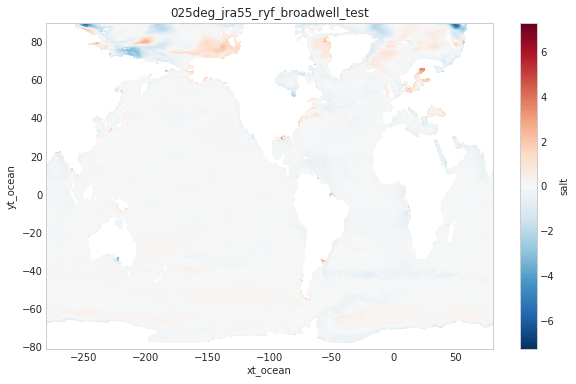

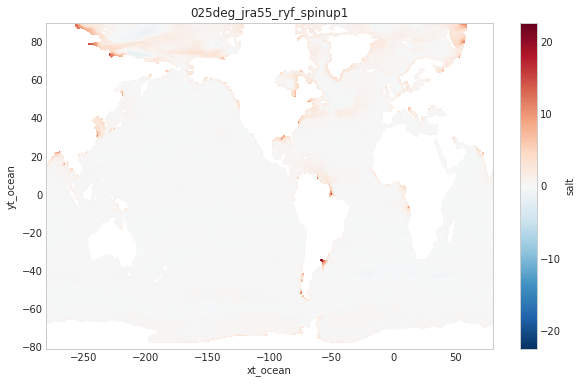

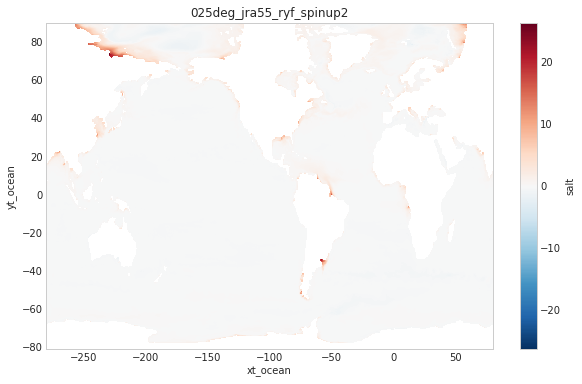

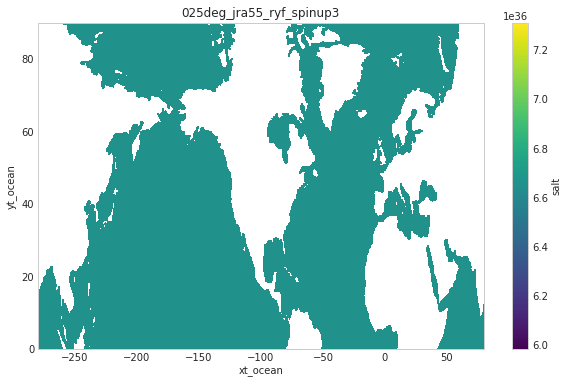

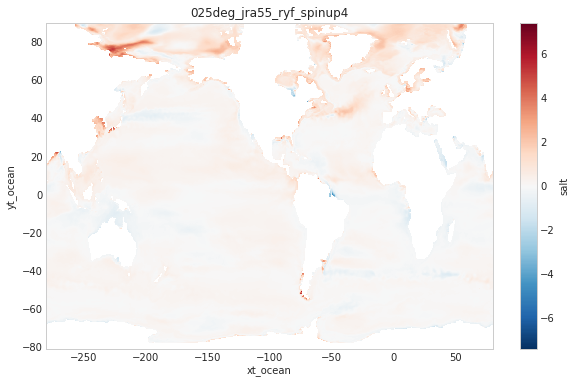

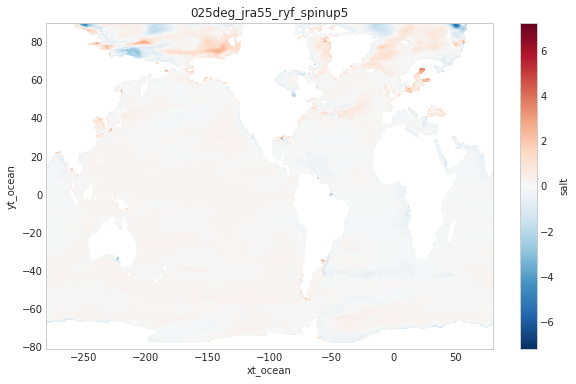

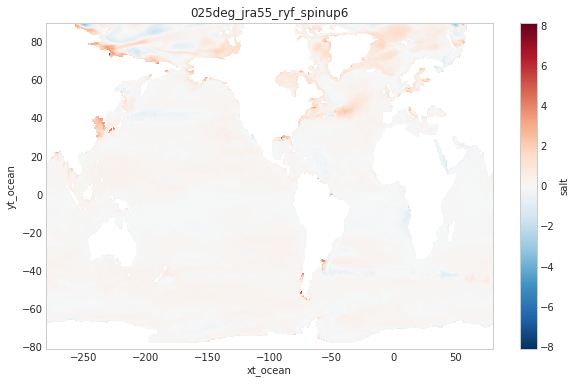

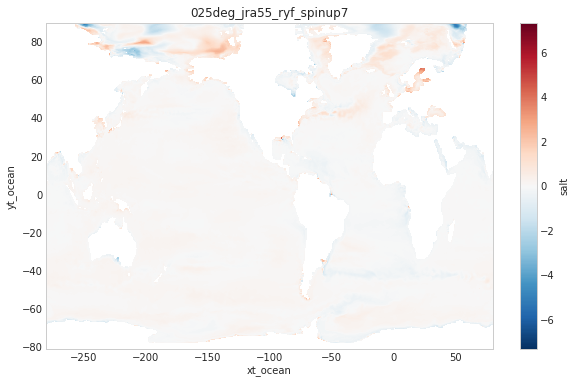

In [36]:
for e in esub[:-1]:
    plt.figure(figsize=(10, 6)) 
    sss2 = cc.get_nc_variable(e, 'ocean.nc', 'salt',n=10).isel(st_ocean=0)
    sss2 = sss2.mean('time')
    diff = sss2 - sss.values
    diff.plot()
    plt.title(e)


## Sea Ice
This part will plot the sea ice extent, compared with obs.

**Currently, only plots MOM cases - still working on CICE output.**

NameError: name 'get_nc_variable' is not defined

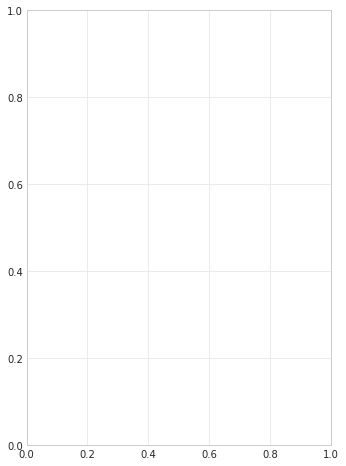

In [37]:
# Assume all files have same grid
#area_t_south = get_nc_variable(e,'ocean_grid.nc','area_t').sel(yt_ocean=slice(-90,-30)).values
#area_t_north = get_nc_variable(e,'ocean_grid.nc','area_t').sel(yt_ocean=slice(30,90)).values
GridFile = '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output000/ocean_grid.nc'
dsg = xr.open_dataset(GridFile, decode_times=False, engine='netcdf4')
area_t_south = dsg.area_t.sel(yt_ocean=slice(-90,-30)).values
area_t_north = dsg.area_t.sel(yt_ocean=slice(30,90)).values

## Doing MOM case
e = expts[-1]
plt.figure(figsize=(12,8))
plt.subplot(121)
ice_area_south = get_nc_variable(e,'ice_month.nc','EXT',
                               time_units='days since 1900-01-01').sel(yt=slice(-90,-30)).groupby('time.month').mean('time')*area_t_south/1.0e6
ice_area_south.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)

plt.subplot(122)    
ice_area_north = get_nc_variable(e,'ice_month.nc','EXT',
                               time_units='days since 1900-01-01').sel(yt=slice(30,90)).groupby('time.month').mean('time')*area_t_north/1.0e6
ice_area_north.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)

# sea ice observation data here:
ObsDirExt = '/g/data/v45/akm157/data/NSIDC/NOAA_G02135_extent_monthly/'
obsExtSHFileList = glob(os.path.join(ObsDirExt, 'sh/*.csv'))
obsExtSHFileList.sort()
obsExtNHFileList = glob(os.path.join(ObsDirExt, 'nh/*.csv'))
obsExtNHFileList.sort()

## Now for ACCESS case


## obs extent:
# just take 20 years 1979-1998 where available:
SH_extent_climatology_obs = np.zeros(12)
import csv
for month in range(12):
	n_years = 0
	#print('opening '+obsExtSHFileList[month])
	with open(obsExtSHFileList[month]) as csvfile:
		reader = csv.reader(csvfile)
		rownum = 0
		for row in reader:
			if (rownum > 0 and float(row[-2])>0 and float(row[0])>1978 \
				and float(row[0])<1999):
				SH_extent_climatology_obs[month] += float(row[-2])
				n_years = n_years + 1
			rownum = rownum + 1
	SH_extent_climatology_obs[month] = SH_extent_climatology_obs[month] / n_years

NH_extent_climatology_obs = np.zeros(12)
import csv
for month in range(12):
	n_years = 0
	#print('opening '+obsExtNHFileList[month])
	with open(obsExtNHFileList[month]) as csvfile:
		reader = csv.reader(csvfile)
		rownum = 0
		for row in reader:
			if (rownum > 0 and float(row[-2])>0 and float(row[0])>1978 \
				and float(row[0])<1999):
				NH_extent_climatology_obs[month] += float(row[-2])
				n_years = n_years + 1
			rownum = rownum + 1
	NH_extent_climatology_obs[month] = NH_extent_climatology_obs[month] / n_years

# plot northern:
plt.subplot(122)
plt.plot(np.arange(12)+1,NH_extent_climatology_obs*1e6,'k--',linewidth=2,label='obs')
plt.title('NH sea ice extent')
plt.legend()
#plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)')
#plt.title('Arctic extent')
#plt.show()

# plot southern:
plt.subplot(121)
plt.plot(np.arange(12)+1,SH_extent_climatology_obs*1e6,'k--',linewidth=2,label='obs')
plt.title('SH sea ice extent')
#plt.ylabel(r'Sea ice extent (10$^{12}$m$^2$)')
#plt.title('Antarctic extent')
#plt.show()


In [ ]:

ice_area_south = get_nc_variable(e,'iceh*-01.nc','aice')#.sel(yt=slice(-90,-30)).mean('time')*area_t_south/1.0e6
ice_area_south.sum(dim='xt').sum(dim='yt').plot(marker='o',label=expt)
